In [12]:
import numpy as np
import matplotlib.pyplot as plt
'''
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack

from numpy.random import randn
from numpy.random import randint
'''

from keras.datasets.mnist import load_data

from keras.models import Sequential

from keras.layers import Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout, BatchNormalization

from keras.optimizers import Adam, SGD, RMSprop

from IPython.display import clear_output, Image

In [7]:
def discriminator():
    
    net = Sequential()
    input_shape = (28, 28, 1)
    dropout_prob = 0.4
    
    # CONV-L with filters=64 kernel=5x5
    net.add(Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(LeakyReLU())
    
    # CONV-L with filters=128 k=5x5
    net.add(Conv2D(128, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    # CONV-L with filters=256 k=5x5
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    # CONV-L with filters=512 k=5x5
    net.add(Conv2D(512, 5, strides=1, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Flatten())
    net.add(Dense(1, activation='sigmoid'))

    return net

In [10]:
discriminator = discriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 256)        

In [15]:
def generator():
    
    net = Sequential()
    dropout_prob = 0.4
    
    net.add(Dense(7*7*256, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    net.add(Reshape((7,7,256)))
    net.add(Dropout(dropout_prob))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(UpSampling2D())
    net.add(Conv2D(64, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(32, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(1, 5, padding='same', activation='sigmoid'))
    #net.add(Activation('sigmoid'))
    
    return net

In [16]:
generator = generator()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_5 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)      

In [19]:
optim_discriminator = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-10)
model_discriminator = Sequential()
model_discriminator.add(discriminator)
model_discriminator.compile(loss='binary_crossentropy', optimizer=optim_discriminator, metrics=['accuracy'])
model_discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 4,311,553
Non-trainable params: 0
_________________________________________________________________


In [20]:
optim_adversarial = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)
model_adversarial = Sequential()
model_adversarial.add(generator)

# Disable layers in discriminator
for layer in discriminator.layers:
    layer.trainable = False

model_adversarial.add(discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])

model_adversarial.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


In [23]:
(trainX, _), (_, _) = load_data()
x_train = np.expand_dims(trainX, axis=-1)
x_train = x_train.astype('float32')
x_train = x_train / 255.0


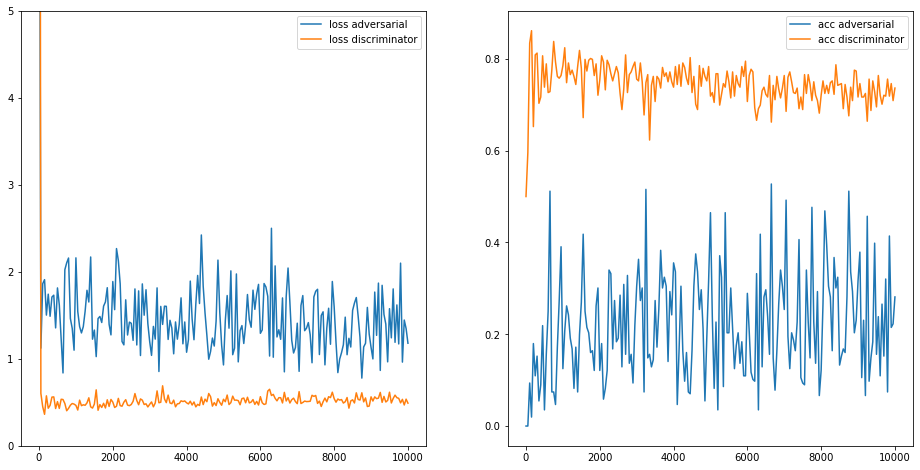

In [27]:
batch_size = 256

vis_noise = np.random.uniform(-1.0, 1.0, size=[16, 100])

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

for i in range(10001):
    
    # Select a random set of training images from the mnist dataset
    images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
    
    # Generate a random noise vector
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    
    # Use the generator to create fake images from the noise vector
    images_fake = generator.predict(noise)
    
    # Create a dataset with fake and real images
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0 

    # Train discriminator for one batch
    d_stats = model_discriminator.train_on_batch(x, y)
    
    # Train the generator
    # The input of th adversarial model is a list of noise vectors. The generator is 'good' if the discriminator classifies
    # all the generated images as real. Therefore, the desired output is a list of all ones.
    y = np.ones([batch_size, 1])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_stats = model_adversarial.train_on_batch(noise, y)
        
    if i % 50 == 0:
        plot_iteration.append(i)
        loss_adv.append(a_stats[0])
        loss_dis.append(d_stats[0])
        acc_adv.append(a_stats[1])
        acc_dis.append(d_stats[1])

        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax1.plot(plot_iteration, loss_adv, label="loss adversarial")
        ax1.plot(plot_iteration, loss_dis, label="loss discriminator")
        ax1.set_ylim([0,5])
        ax1.legend()

        ax2.plot(plot_iteration, acc_adv, label="acc adversarial")
        ax2.plot(plot_iteration, acc_dis, label="acc discriminator")
        ax2.legend()

        plt.show()
       
    # Optional, print losses instead of plotting with:
    # print("{}: [Dis. loss: {:.4f}, acc: {:.4f}] [Gen. loss: {:.4f}, acc: {:.4f}]".format(i, d_stats[0], d_stats[1], a_stats[0], a_stats[1]))

    if i % 500 == 0:
        # Visualize the performance of the generator by producing images from the test vector
        images = generator.predict(vis_noise)
        # Map back to original range
        #images = (images + 1 ) * 0.5
        plt.figure(figsize=(10,10))
        
        for im in range(images.shape[0]):
            plt.subplot(4, 4, im+1)
            image = images[im, :, :, :]
            image = np.reshape(image, [28, 28])
            
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'output/mnist-normal/{i}.png')
        plt.close('all')

In [29]:
import imageio

filenames = [r'output/mnist-normal/{}.png'.format(i * 500) for i in range(20)]
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(r'output/mnist-normal/learning.gif', images, duration=0.5)

Image(url='output/mnist-normal/learning.gif')

In [38]:
# save the learned models inside h5 files

filename = f'output/Networks/discriminator_epoch_10k.h5'
model_discriminator.save(filename)

filename = f'output/Networks/generator_epoch_10k.h5'
model_adversarial.save(filename)

# Save the generator-discriminator independently
filename = f'output/Discriminator_epoch_10k.h5'
model_discriminator.save(filename)

filename = f'output/Generator_epoch_10k.h5'
model_adversarial.save(filename)

[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
[[-0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8
  -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8
  -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8
  -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8
  -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8
  -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8
  -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -0.8
  -0.8 -0.8]]
[[-0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -

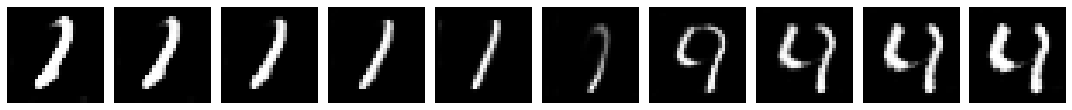

In [57]:
plt.figure(figsize=(15,4))

for i in range(10):
    noise = np.zeros([1,100]) - 1 + (i * 0.2)
    print(noise)
    images = generator.predict(noise)
    
    image = images[0, :, :, :]
    image = np.reshape(image, [28, 28])
          
    plt.subplot(1, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

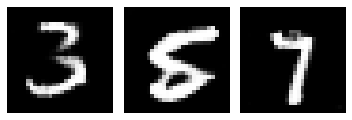

In [59]:
# Generate two random vectors
a = np.random.uniform(-1.0, 1.0, size=[1, 100])
b = np.random.uniform(-1.0, 1.0, size=[1, 100])

# Reshape the random vectors to the shape of mnist element
image_a = np.reshape(generator.predict(a)[0], [28, 28])
image_b = np.reshape(generator.predict(b)[0], [28, 28])

# Sum the reshaped elements
image_sum = np.reshape(generator.predict(b -a)[0], [28, 28])

plt.figure(figsize=(5,4))

# Plot the first image
plt.subplot(1,3,1)
plt.imshow(image_a, cmap='gray')
plt.axis('off')

# Plot the second image
plt.subplot(1,3,2)
plt.imshow(image_b, cmap='gray')
plt.axis('off')

# Plot the subtraction of first image to second image
plt.subplot(1,3,3)
plt.imshow(image_sum, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

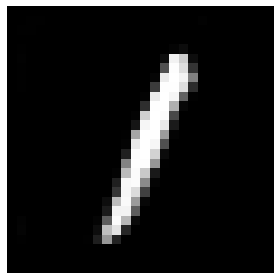

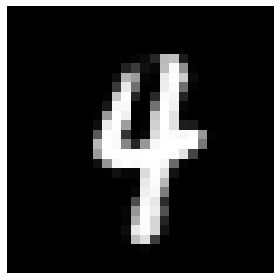

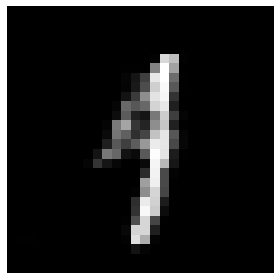

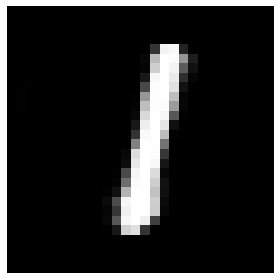

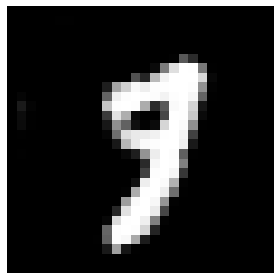

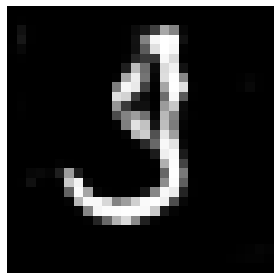

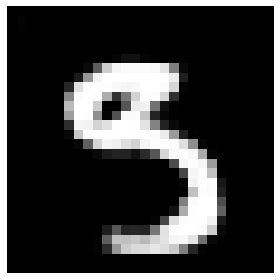

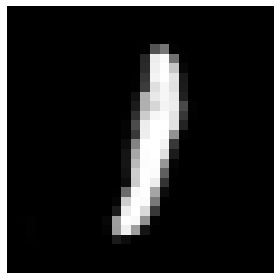

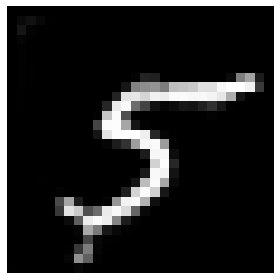

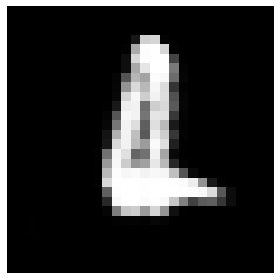

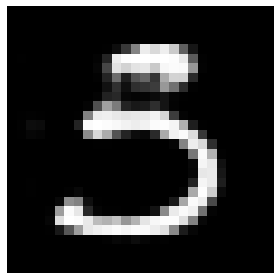

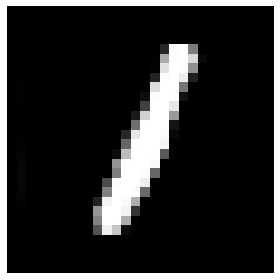

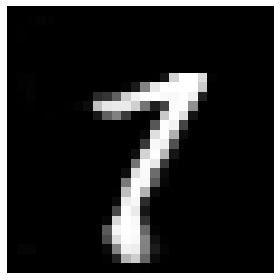

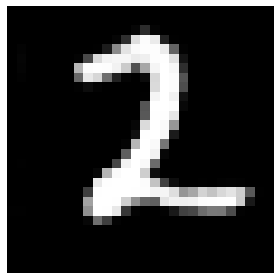

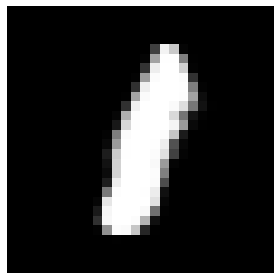

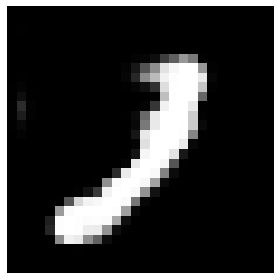

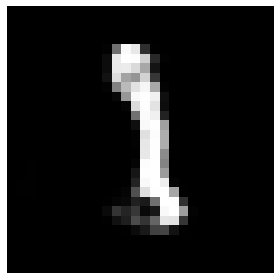

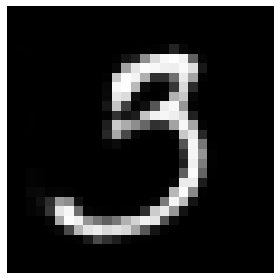

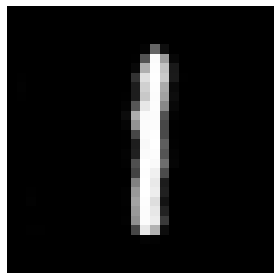

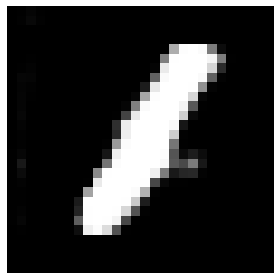

KeyboardInterrupt: 

In [64]:
# Plot character from random noise vector
import time

# Generate random 100 digits
for i in range(10000):
    noise = np.random.uniform(-1.0, 1.0, size=[1, 100])
    gen_img = np.reshape(generator.predict(noise)[0], [28, 28])
    
    plt.figure()
    plt.imshow(gen_img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'output/Generated_char/{i}.png')
    plt.close('all')
    time.sleep(1)
